<a href="https://colab.research.google.com/github/sumanapalle065/LC25000-Hybrid-Architecture-using-DL/blob/main/mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 !unzip "/content/drive/MyDrive/LC25000.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [4]:

import cv2
import numpy as np
import os
import glob #for searching based on filename patterns which is generally used to get file paths
import matplotlib.pyplot as matplotlib
import random
import tqdm

from PIL import Image, ImageEnhance

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score

import seaborn as sns

from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [5]:
#load lung_colon_image_dataset
lung_colon_image_dataset=glob.glob("/content/lung_colon_image_set/*/*/*")
lung_colon_image_dataset

['/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4811.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1683.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2352.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4206.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4349.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2843.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca304.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca3998.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4873.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1788.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1796.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1618.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonc

In [6]:
len(lung_colon_image_dataset)

25000

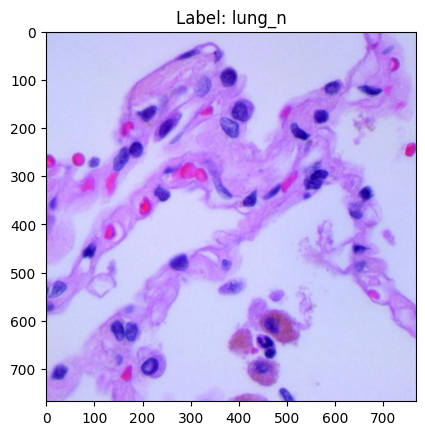

In [7]:
# Select an image path at random from datset
random_image_path = random.choice(lung_colon_image_dataset)
# Read it in using OpenCV with the selected path
image = cv2.imread(random_image_path)
# It needs to be in RGB format (because it's a picture of a lung so is not BGR) so convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Get the label of the image from its parent folder name; assumed to be the label
label = random_image_path.split('/')[-2]
# Display with matplotlib's imshow function using RGB format
matplotlib.imshow(image_rgb)
# Setting the title of the plot using the extracted label to denote which class an image belongs to
matplotlib.title(f"Label: {label}")
# Displaying the image along with the title in a plot window
matplotlib.show()

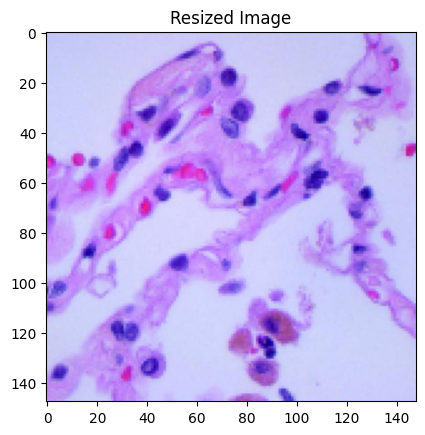

In [8]:
# Resize the image to 148x148 with OpenCV's resize function for a fixed input size.
img = cv2.resize(image, (148, 148))
# Change the resized image from BGR color space to RGB color space so that colors are represented correctly
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Show the resized image with matplotlib using imshow
matplotlib.imshow(img_rgb)
# Set plot title to indicate the image size scaled
matplotlib.title("Resized Image")
# Displaying the resized image in a plot window
matplotlib.show()

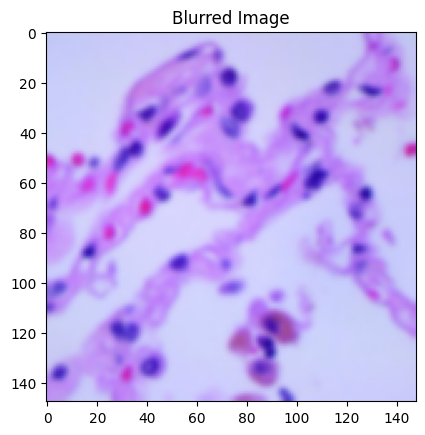

In [9]:
#Apply Gaussian blur to the resized image with a 5x5 kernel, which will help in reducing noise and details.
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
# Convert the blurred image into color space RGB to display the correct color
blurred_img_rgb = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB)
# Show the blur image with matplotlib's imshow function
matplotlib.imshow(blurred_img_rgb)
# The title of the plot to be blurred image
matplotlib.title("Blurred Image")
# Display the blurry image in a plot window
matplotlib.show()

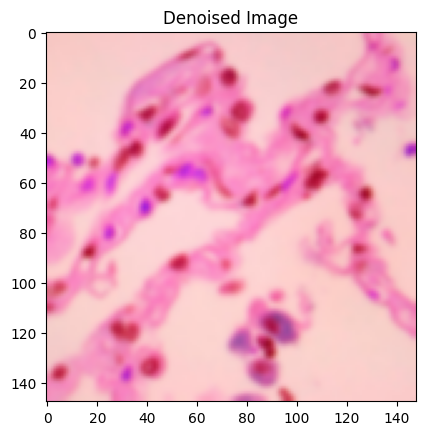

In [10]:
# Converting the already blurred image (which was before in RGB format) to BGR color space again.
denoised_img_rgb = cv2.cvtColor(blurred_img_rgb, cv2.COLOR_BGR2RGB)
# Display the image to be denoised using matplotlib's imshow function
matplotlib.imshow(denoised_img_rgb)
# Captioning the plot with a title to indicate that the image is perceived as denoised.
matplotlib.title("Denoised Image")
# Plotting the image in a plot window with the title "Denoised Image
matplotlib.show()

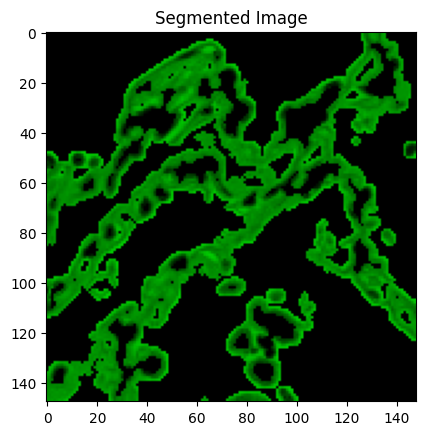

In [11]:
# Convert RGB to grayscale while making use of the cvtColor function in OpenCV
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply Otsu's thresholding to the previous image. It creates the result in binary which is inverted.
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Capture the contours in the thresholded image with OpenCV's findContours function, to directly detect the boundaries of objects
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Create empty mask of the same size to that of the initial image, and initialized to zero (black).
mask = np.zeros_like(img)
# Draw the detected contours on the mask in green color with thickness 2 using OpenCV's drawContours function
cv2.drawContours(mask, contours, -1, (0, 255, 0), 2)
# Use the bitwise AND operation to isolate the segmented region from the original image using the mask
segmented_image = cv2.bitwise_and(img, mask)
# Convert the segmented image from BGR color space to RGB so that colors are accurately displayed
matplotlib.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
# Display the segmented image by calling matplotlib's imshow function
matplotlib.title("Segmented Image")
# Set the title of the plot to indicate that the image is the segmented version
matplotlib.show()
# Display the segmented image in a plot window

In [12]:
from tqdm import tqdm
# Initialize an empty list 'processed_images' to store the processed image data
processed_images = []
# Initialize an empty list 'labels' to hold the corresponding labels of the images
labels = []
# Define a class dictionary called 'label_map' that maps specific class names
label_map = {
    "lung_aca": 0,
    "colon_n": 1,
    "lung_n": 2,
    "lung_scc": 3,
    "colon_aca": 4,
}
# Iterate over the list of path to each image  with a progress bar
for img_path in tqdm(lung_colon_image_dataset):
  # Reading the image from the current path using imread function of OpenCV
    img = cv2.imread(img_path)
    # If the image has failed to load properly, in other words it is None, skip the iteration and move to the next image
    if img is None:
      # Resize image to 148x148 pixels to standardize the size of input
        continue
    img = cv2.resize(img, (148, 148))
 # To blur the resized image by applying  kernel to remove noise in the image and blur.
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Convert the blurry image to LAB color space-for better illumination handling
    lab = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2LAB)
    # Split the LAB image into channels L, A and B
    l, a, b = cv2.split(lab)
    # Create a CLAHE object with some clip limit, tile grid size
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Applying CLAHE on the L channel (luminance) for contrast enhancement
    cl = clahe.apply(l)
    # Merging enhanced CLAHE L channel with original A and B channels
    lab_clahe = cv2.merge((cl, a, b))
    # Convert the LAB image back to BGR color space after CLAHE application
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    # Convert CLAHE-enhanced image to grayscale for thresholding and contour detection
    gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    # Use OpenCV's Otsu's thresholding to the grayscale image to get a black and white image with inverted colors
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours of the object on the thresholded image using OpenCV's findContours function to detect boundaries and outlines
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Create a mask of zeros filled with black for overlay onto the contours
    mask = np.zeros_like(img)
    # Detect contours in mask, draw them on it with green color, thickness of 2
    cv2.drawContours(mask, contours, -1, (0, 255, 0), 2)
    # Apply mask to the original image using bitwise AND to segment region of interest
    segmented_image = cv2.bitwise_and(img, mask)
    # Convert image from BGR to RGB for appropriate visualisation
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
 # Normalize the segmented image by converting its pixel values to float32 and scaling them to the range
    normalized_img = segmented_image_rgb.astype(np.float32) / 255.0
    # Append normalized image to 'processed_images
    processed_images.append(normalized_img)
    # Extract the class name from the parent directory of the image path that will be assumed as a label
    label = img_path.split(os.path.sep)[-2]
    # Check whether the extracted label is in 'label_map' dictionary or not
    if label in label_map:
      # If label is in 'label_map', append the numeric label corresponding to that one to the 'labels' list
        labels.append(label_map[label])

100%|██████████| 25000/25000 [02:09<00:00, 192.42it/s]


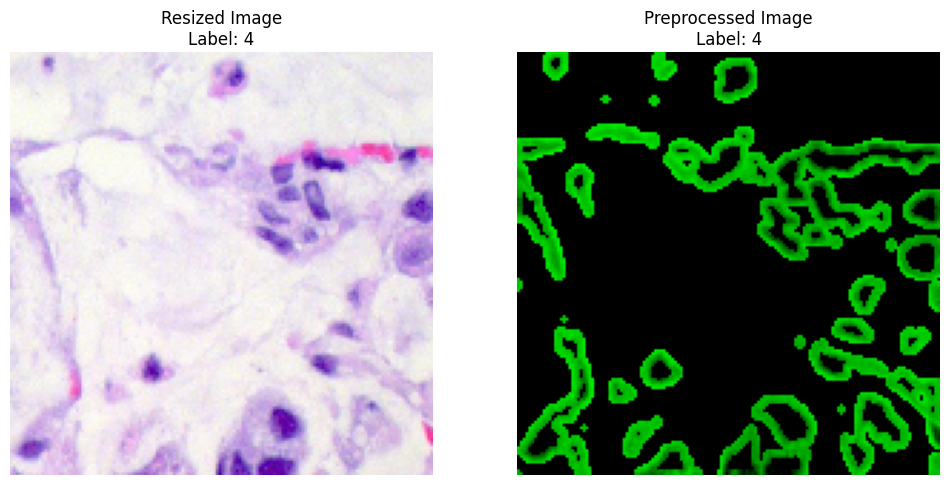

In [13]:
import random
import matplotlib.pyplot as plt

# Select a random image index from the processed images
random_index = random.randint(0, len(processed_images) - 1)

# Get the corresponding original image and its preprocessed version
random_image_path = lung_colon_image_dataset[random_index]  # Get the path of the random image
original_image = cv2.imread(random_image_path)  # Read the original image

# Resize the original image (simulating the same resize step as in preprocessing)
resized_image = cv2.resize(original_image, (148, 148))

# Get the preprocessed (segmented) image and its label
preprocessed_image = processed_images[random_index]
label = labels[random_index]

# Plot the original resized image and preprocessed image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the resized image on the first subplot
axes[0].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
axes[0].set_title(f"Resized Image\nLabel: {label}")
axes[0].axis('off')  # Hide axes for the resized image

# Display the preprocessed image (segmented image) on the second subplot
axes[1].imshow(preprocessed_image)
axes[1].set_title(f"Preprocessed Image\nLabel: {label}")
axes[1].axis('off')  # Hide axes for the preprocessed image

# Show the images
plt.show()


In [14]:
# The list of processed images should be converted into a form that is easily used and manipulated within deep learning models by using a NumPy array.
processed_images_array = np.array(processed_images)
# Convert the list of labels into a NumPy array to match the processed images for model training
labels_array = np.array(labels)
# Print the shape of the 'processed_images_array' to make sure it consists of the correct number of dimensions for all the processed images, that is, the count of images, height, width, and channel
print("Shape of processed_images_array:", processed_images_array.shape)
# Print the shape of 'labels_array' to find out how many labels
print("Shape of labels_array:", labels_array.shape)


Shape of processed_images_array: (25000, 148, 148, 3)
Shape of labels_array: (25000,)


In [15]:
# Splitting the dataset into training and testing sets using sklearn's train_test_split function
X_train, X_test, y_train, y_test = train_test_split(
    # By setting the size of test to 20 percent of the data, you would then train on 80 percent and test on 20 percent.
    processed_images_array, labels_array, test_size=0.2, random_state=100
    # Set random state for reproducibility so the split will always be the same
)

In [16]:
#Print the shape of the training data (X_train) to confirm the dimensions, which include the number of samples and image dimensions
print("X_train shape:", X_train.shape)
#End This prints out shape of testing data X_test, verifying dimensions. It includes number of samples and size of images.
print("X_test shape:", X_test.shape)
# Print the shape of the training labels (y_train) for confirmation of the number of labels in the training dataset
print("y_train shape:", y_train.shape)
# Print the shape of the testing labels (y_test) to check how many labels there are in the testing set
print("y_test shape:", y_test.shape)

X_train shape: (20000, 148, 148, 3)
X_test shape: (5000, 148, 148, 3)
y_train shape: (20000,)
y_test shape: (5000,)


In [17]:
# Convert y_train to one-hot vector in Keras using to categorical
y_train = to_categorical(y_train, num_classes=5)
#Setting num_classes to 5 because we have 5 classes in the dataset. As defined in label_map
y_test = to_categorical(y_test, num_classes=5)
# Transform the testing labels into one-hot encoded format similar to the training labels

In [18]:
#Print the shape of one-hot encoded training labels, y_train to see how many samples and what are the dimensions of a one-hot encoded label
print("y_train_categorical shape:", y_train.shape)
# Print shape of the one-hot encoded testing labels (y_test) to confirm the number of samples and the dimensionality of the one-hot encoded label
print("y_test_categorical shape:", y_test.shape)

y_train_categorical shape: (20000, 5)
y_test_categorical shape: (5000, 5)


In [19]:
# Input layer definition for the model, which takes images of size (148, 148, 3) in terms of height, width, and RGB channels.
input_layer = Input(shape=(128, 128, 3))
# Load the MobileNetV2 model with pre-trained weights from ImageNet but set include_top=False in order to use as a feature extractor
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)
# Loading InceptionV3 model with weights pre-trained on ImageNet but removing the top layers by using include_top=False
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)
# Load EfficientNetB7 pre-trained with ImageNet weights excluding top layers set to False for using as a feature extractor.
efficientnetb7_base = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=input_layer)

# Set all of the models' pre-trained layers to frozen.
mobilenetv2_base.trainable = False
inceptionv3_base.trainable = False
efficientnetb7_base.trainable = False

# Get the outputs of all models
mobilenetv2_output = mobilenetv2_base.output
inceptionv3_output = inceptionv3_base.output
efficientnetb7_output = efficientnetb7_base.output

# Add CNN layers on top of MobileNetV2 output
mobilenetv2_output = Conv2D(256, (3, 3), activation='relu', padding='same')(mobilenetv2_output)
mobilenetv2_output = MaxPooling2D((2, 2))(mobilenetv2_output)

# Add CNN layers on top of InceptionV3 output
inceptionv3_output = Conv2D(256, (3, 3), activation='relu', padding='same')(inceptionv3_output)
inceptionv3_output = MaxPooling2D((2, 2))(inceptionv3_output)

# Add CNN layers on top of EfficientNetB7 output
efficientnetb7_output = Conv2D(256, (3, 3), activation='relu', padding='same')(efficientnetb7_output)
efficientnetb7_output = MaxPooling2D((2, 2))(efficientnetb7_output)

# Global Average Pooling for all models
mobilenetv2_output = GlobalAveragePooling2D()(mobilenetv2_output)
inceptionv3_output = GlobalAveragePooling2D()(inceptionv3_output)
efficientnetb7_output = GlobalAveragePooling2D()(efficientnetb7_output)

# Concatenate the outputs from all models
combined_output = Concatenate()([mobilenetv2_output, inceptionv3_output, efficientnetb7_output])
# Top the hybrid model with unique thick layers.
x = Dense(1024, activation='relu')(combined_output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# Adding the Dense layer with 1020 units and ReLU activation function
x = Dense(1020, activation='relu')(x)
# Applying BatchNormalization in order to normalize activations and improve convergence
x = BatchNormalization()(x)
# Dropout with 0.5 rate; this helps reduce overfitting where a half of the units are dropped at training time randomly
x = Dropout(0.5)(x)
# Another Dense layer of 1020 units with ReLU
x = Dense(1020, activation='relu')(x)
# BatchNormalization again for normalization of activations
x = BatchNormalization()(x)
# Dropout again with a dropout rate of 0.5 to discourage overfitting
x = Dropout(0.5)(x)
# Output layer of 5 units since we have 5 classes, and sigmoid activation for multiclass classification

output = Dense(5, activation='sigmoid')(x)
# Sigmoid activation outputs in [0, 1] so it's suitable for multiclass problems, and we assume independence between the class probabilities
hybrid_model = Model(inputs=input_layer, outputs=output)
# Hybrid Model: A model which has been defined as follows: Input layer Output layer
# loss function for the classification problem: since it is a multicategorical problem, use categorical crossentropy
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     # metric for which we will compute its accuracy while training
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# model summary to understand architecture and number of parameters
hybrid_model.summary()

<ipython-input-19-b8d01c69555a>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 64)     │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 64)     │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 64)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 64)     │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 64)     │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 64)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 104,616,912 (399.08 MB)

 Trainable params: 16,452,329 (62.76 MB)

 Non-trainable params: 88,164,583 (336.32 MB)

In [20]:
#Save the best model based on validation accuracy at training time with ModelCheckpoint
checkpoint = ModelCheckpoint(
    # monitor will specify argument, which refers to the validation accuracy 'val_accuracy', to make model performance evaluation
    './BEST_Acc_save_MODEL.keras',
    monitor='val_accuracy',
    # means the message will be printed out when models are saved
    verbose=1,
    #makes sure the best model for validation accuracy is saved.
    save_best_only=True,
    #means the model whose validation accuracy reaches its highest will be saved
    mode='max',
    # means at each epoch's end, the model will be saved
    save_freq='epoch'
)


In [ ]:
# Create a KFold cross-validation object with 5 splits. Shuffle the data before splitting. Set the random seed in order to get reproducible results
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize an empty list that will store the accuracy values for each fold
fold_accuracies = []
# Iterate through the KFold splits and create training and validation sets for each fold
for train_index, val_index in kf.split(X_train):
  #are the indices that split the training data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    # Using the indices to split X_train and y_train into training and validation subsets for the current fold
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Assigning the hybrid_model to a new variable 'model' for each fold (optional, but useful for avoiding state conflicts)
    model = hybrid_model
# Training the model on the current training fold and validating it on the corresponding validation fold
    history = model.fit(X_train_fold, y_train_fold,
                        # Fitting the model using the data for training
                        epochs=10,# Train on 10 epochs with batch size of 10
                        validation_data=(X_val_fold, y_val_fold),
                        # And append checkpoint callback to save the best model according to val accuracy during training
                        batch_size=10,
                        callbacks=[checkpoint])

Epoch 1/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8654 - loss: 0.3412
Epoch 1: val_accuracy improved from 0.83921 to 0.85631, saving model to ./BEST_Acc_save_MODEL.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 243s 543ms/step - accuracy: 0.8654 - loss: 0.3412 - val_accuracy: 0.8563 - val_loss: 0.3626
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8888 - loss: 0.2817
Epoch 2: val_accuracy improved from 0.85631 to 0.87671, saving model to ./BEST_Acc_save_MODEL.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 83s 249ms/step - accuracy: 0.8888 - loss: 0.2817 - val_accuracy: 0.8767 - val_loss: 0.3151
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9013 - loss: 0.2619
Epoch 3: val_accuracy did not improve from 0.87671
334/334 ━━━━━━━━━━━━━━━━━━━━ 79s 236ms/step - accuracy: 0.9013 - loss: 0.2619 - val_accuracy: 0.8587 - val_loss: 0.3628
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9016 - loss: 0.2564
Epoch 4: val_accuracy did not improv

In [ ]:
hybrid_model1 = load_model('/content/BEST_Acc_save_MODEL.keras')

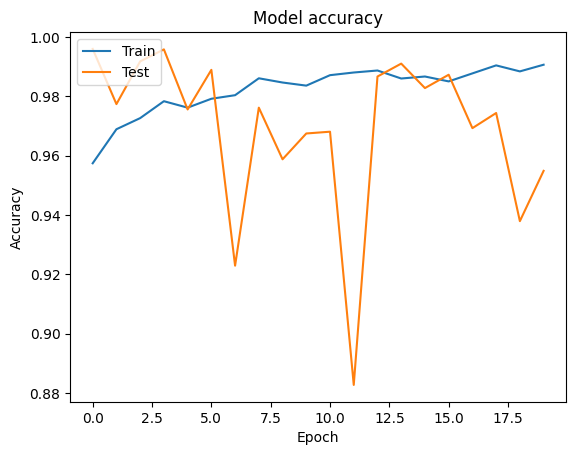

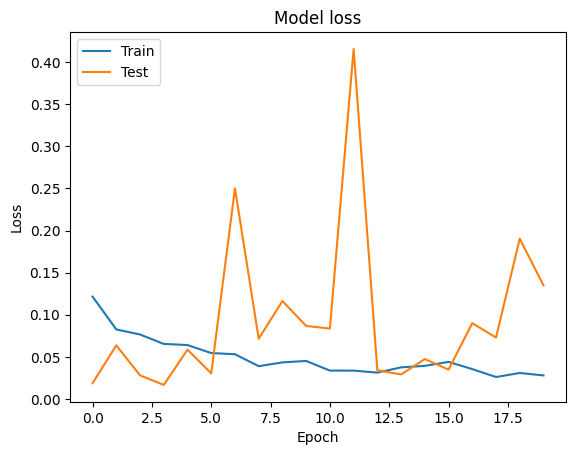

In [ ]:
#Plotting the training accuracy from the history object with matplotlib
matplotlib.plot(history.history['accuracy'])
#is a list with all the accuracy values for the training set over each epoch
matplotlib.plot(history.history['val_accuracy'])
#Plotting the validation accuracy from the history object
matplotlib.title('Model accuracy')
# is a list with all the validation accuracy values over each epoch
matplotlib.ylabel('Accuracy')
#Give the title of the plot to indicate that it displays the model accuracy
matplotlib.xlabel('Epoch')
# Add a legend to the training and validation accuracy curves; 'Train' refers to training accuracy and 'Test' refers to validation accuracy
matplotlib.legend(['Train', 'Test'], loc='upper left')
# Display the plot with accuracy vs epochs
matplotlib.show()

# Plot the training loss from the history object with matplotlib
matplotlib.plot(history.history['loss'])
#is a list of loss values over each epoch for the train set
matplotlib.plot(history.history['val_loss'])
# Plot the validation loss from the history object
matplotlib.title('Model loss')
#is a list of the validation loss over each epoch
matplotlib.ylabel('Loss')
# Set the title of the plot to indicate that it's showing the model loss
matplotlib.xlabel('Epoch')
# Adds the legend to distinguish between the training and validation loss curves
matplotlib.legend(['Train', 'Test'], loc='upper left')
# it refers to the training loss curve and 'For Test, to the validation loss curve'
matplotlib.show()
# Renders the plot containing loss against epochs


In [ ]:
#Evaluate the model on the current training fold to yield loss and accuracy
train_loss, train_acc = hybrid_model1.evaluate(X_train_fold, y_train_fold)
# Print out training accuracy (train_acc) after evaluating the model on the training fold
print('\nTrain accuracy:', train_acc)

417/417 ━━━━━━━━━━━━━━━━━━━━ 119s 178ms/step - accuracy: 0.9823 - loss: 0.0512

Train accuracy: 0.9817759394645691


In [ ]:
#Evaluate the model on the current validation fold to calculate loss and accuracy.
test_loss, test_acc = hybrid_model1.evaluate(X_val_fold, y_val_fold)
# Prints the accuracy of the validation after calling the function, which evaluates the model on the validation fold
print('\nTest accuracy:', test_acc)

209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.9942 - loss: 0.0236

Test accuracy: 0.9936993718147278


In [ ]:

# Use the hybrid_model1 to provide predictions for the training fold.
y_pred = hybrid_model1.predict(X_train_fold)

# Create class labels based on the anticipated probability.
y_pred_classes = np.argmax(y_pred, axis=1)

417/417 ━━━━━━━━━━━━━━━━━━━━ 100s 173ms/step


In [ ]:
y_train_fold = np.argmax(y_train_fold, axis=1)

In [ ]:
# Calculate average precision score over predicted classes
precision = precision_score(y_train_fold, y_pred_classes, average='weighted')
#averages precisions of all classes weighted by their frequency
f1 = f1_score(y_train_fold, y_pred_classes, average='weighted')
# Calculates F1 score over predicted classes
print("Precision:", precision)
# Print the average precision score on training data
print("F1-score:", f1)#Print the training F1 score

Precision: 0.982042528532175
F1-score: 0.9817039494183121


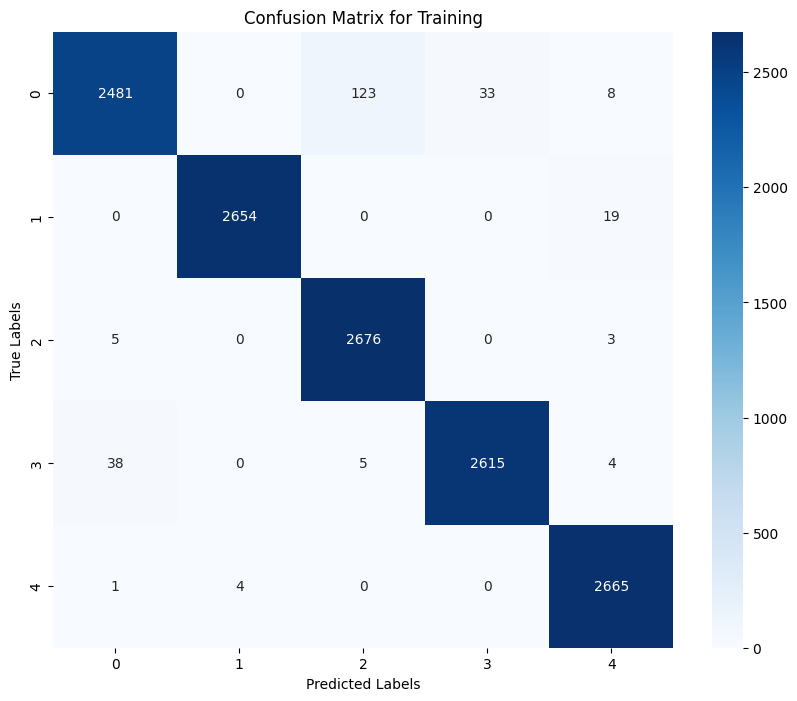

In [ ]:
# True-label-based confusion matrix and class-label-based predictions
cm = confusion_matrix(y_train_fold, y_pred_classes)
# The confusion matrix is the number of correct and incorrect predictions for each class as classified in true positives,
matplotlib.figure(figsize=(10, 8))
# Adjust figure size such that it fits large enough for clear display in the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
#Use seaborn's heatmap to show the confusion matrix with annotations
matplotlib.xlabel('Predicted Labels')
#Apply the color map to 'Blues' so that the heatmap looks quite pretty.
matplotlib.ylabel('True Labels')
#Set up the x-axis and y-axis labels to show the predicted labels and the true labels, respectively.
matplotlib.title('Confusion Matrix for Training')
# Displaying a title to the confusion matrix heatmap indicating which it shows is the training data confusion matrix
# Displaying the confusion matrix heatmap
matplotlib.show()

In [ ]:
# Computing the sensitivity (also called recall or true positive rate) for the first class, that is, class 0
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
# Print the sensitivity for the first class
print('Sensitivity : ', sensitivity)
# Computing specificity (or true negative rate) for the second class, that is, class 1
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# Print the specificity for the second class.
print('Specificity : ', specificity)

Sensitivity :  1.0
Specificity :  1.0


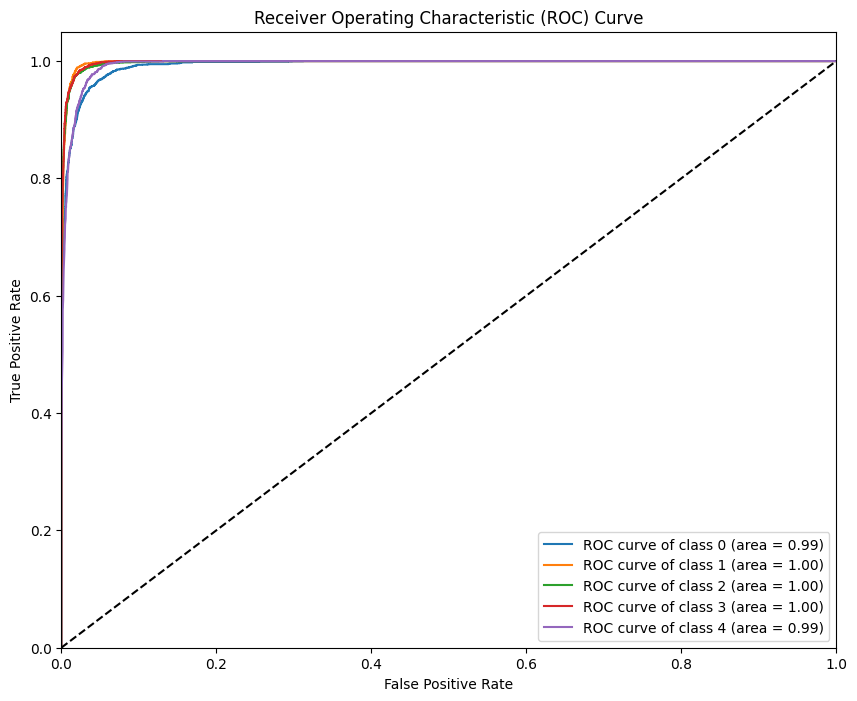

In [ ]:
#calculate roc auc curve plot graph
# To calculate the ROC AUC, binarize the labels.
y_train_bin = label_binarize(y_train_fold, classes=range(5))
y_pred_bin = y_pred

# Initializes dictionaries to store false positive rate (fpr), true positive rate (tpr) and ROC AUC values for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# Loops the value 0 through 4
for i in range(5):
  # For each class, it gets the false positive rate (fpr) and the true positive rate (tpr) by roc_curve
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_pred_bin[:, i])
     # is the actual binary labels for class i and 'y_pred_bin[:, i]' the predicted binary probabilities for class
    roc_auc[i] = auc(fpr[i], tpr[i])
    #is used in order to skip over the threshold values returned by roc_curve since they aren't needed here

# Drawing ROC Curve for each of the 5 classes
matplotlib.figure(figsize=(10, 8))
# Create a figure to plot the ROC curves of all 5 classes

# Loop over the class and plot ROC curve for the class
for i in range(5):
  #Each curve with the number of the class and its corresponding AUC value, formatted to two places.
    matplotlib.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
#Finally, matplotlib will be used to plot the curves; these will illustrate the performance of the model in distinguishing each class from the rest.

# Plotting a diagonal line that reflects the performance of a random classifier with no discrimination
matplotlib.plot([0, 1], [0, 1], 'k--')
# The line provides a baseline against which it can be tested how well the model performs. with no real ability to distinguish classes
matplotlib.xlim([0.0, 1.0])
matplotlib.ylim([0.0, 1.05])
# Labelling x-axis as 'False Positive Rate' (FPR) which represents the ratio of negative which was classified as positive
matplotlib.xlabel('False Positive Rate')
# Labelling the y-axis as 'True Positive Rate' (TPR) which represents ratio of correct positives
matplotlib.ylabel('True Positive Rate')
# Adding a title 'Receiver Operating Characteristic (ROC) Curve' to describe the type of plot
matplotlib.title('Receiver Operating Characteristic (ROC) Curve')
# Adding a legend to the plot to label the different curves; the 'lower right' position places the legend in the lower-right corner
matplotlib.legend(loc="lower right")
# Displaying the plot with all ROC curves for the different classes
matplotlib.show()# Show the plot

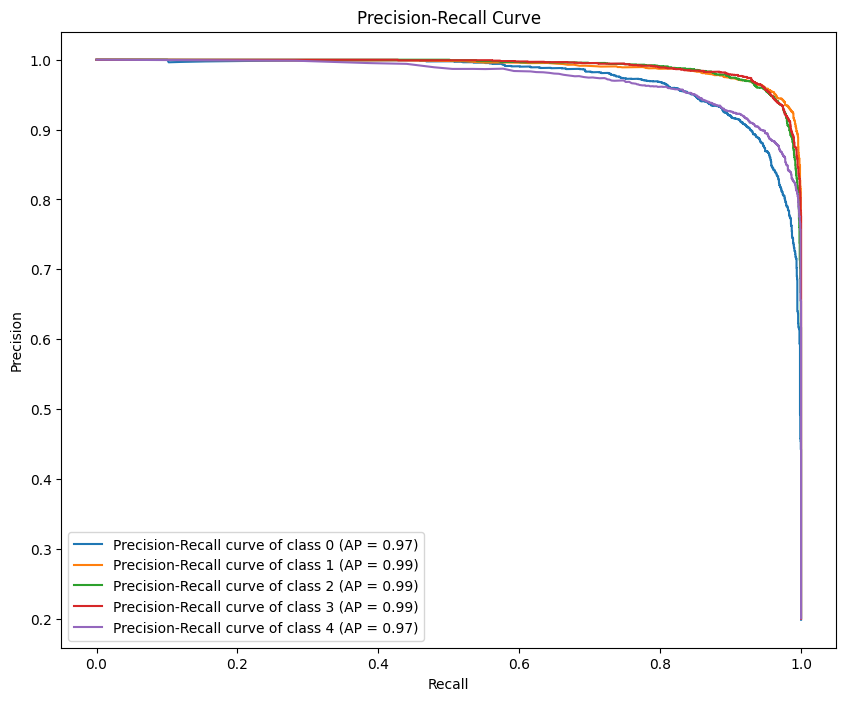

In [ ]:
# Initialize dictionaries to store the precision, recall, and average precision for each class
precision = dict()
# Iterate over the 5 classes (0 to 4)
recall = dict()
# For each class, get precision and recall using precision_recall_curve
average_precision = dict()
# Obain the average precision (AP) of each class using the function average_precision_score that summarizes the precision-recall curve into a single number
for i in range(5):
 # Draw a figure to plot Precision-Recall curves for all 5 classes
    precision[i], recall[i], _ = precision_recall_curve(y_train_bin[:, i], y_pred_bin[:, i])
    #Set figure size for your plot large enough to be visualized
    average_precision[i] = average_precision_score(y_train_bin[:, i], y_pred_bin[:, i])
# Each curve is labeled with the class number and the corresponding AP value, rounded to two decimal places

# The x-axis is titled 'Recall, that is, true positive rate or proportion of actual positives correctly identified.
matplotlib.figure(figsize=(10, 8))
# which is the proportion of those actually positive who are correctly classified as such.
for i in range(5):
  # The title 'Precision-Recall Curve' explains what kind of plot is it.
    matplotlib.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))
# Add a legend to the plot to label the different curves; the 'lower left' position places the legend in the lower-left corner
# that is, true positive rate or proportion of actual positives correctly identified.
matplotlib.xlabel('Recall')
# Display the plot with all Precision-Recall curves for the different classe
matplotlib.ylabel('Precision')
# Show the plot
matplotlib.title('Precision-Recall Curve')
# Each curve is labeled with the class number and the corresponding AP value, rounded to two decimal
matplotlib.legend(loc="lower left")
matplotlib.show()


In [ ]:
## Predict the output of the validation set (X_val_fold) according to the trained model: hybrid_model1
y_pred = hybrid_model1.predict(X_val_fold)
# Convert predicted probabilities to class labels by selecting index of max probability for each sample
y_pred_classes = np.argmax(y_pred, axis=1)

209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 172ms/step


In [ ]:
#Convert the one-hot encoded ground truth labels in 'y_val_fold' to class labels
y_val_fold = np.argmax(y_val_fold, axis=1)

In [ ]:
# Calculate the precision and F1-score of the validation set y_val_fold and y_pred_classes by averaging the weights.
precision = precision_score(y_val_fold, y_pred_classes, average='weighted')
# Precision measures the fraction of true positive predictions over all positive predictions, that is to say, how many of the predicted positive labels are correct
f1 = f1_score(y_val_fold, y_pred_classes, average='weighted')
# F1-score is the harmonic mean of precision and recall balancing both

# Print out the precision and F1-score for the validation set:
print("Precision:", precision)
#In order to check the model's classification performance against an imbalance class
print("F1-score:", f1)

Precision: 0.9938063070199331
F1-score: 0.9936976890715551


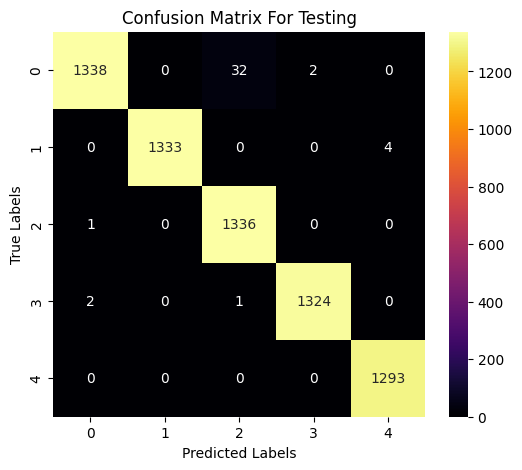

In [ ]:
#confution matrix
# To compute the confusion matrix, use the real labels (`y_val_fold`) and predicted labels (`y_pred_classes`).
cm = confusion_matrix(y_val_fold, y_pred_classes)
# Create a new figure for the plot with dimensions 6x5 inches
matplotlib.figure(figsize=(6, 5))
# Use the Seaborn library to create a heatmap of the confusion matrix.
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=range(5), yticklabels=range(5))
# Put "Predicted Labels" as the label for the x-axis.
matplotlib.xlabel('Predicted Labels')

# Put "True Labels" as the label for the y-axis.
matplotlib.ylabel('True Labels')
# Make "Confusion Matrix For Testing" the plot's title.
matplotlib.title('Confusion Matrix For Testing')

# Display the heatmap plot
matplotlib.show()


In [ ]:
# Calculation for Sensitivity (True Positive Rate) for class 0
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
#The number of actual positives correctly identified
print('Sensitivity : ', sensitivity1 )
# Specificity or True Negative Rate for class 1
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
# Specificity is the number of actual negatives correctly classifier
print('Specificity : ', specificity1)

Sensitivity :  1.0
Specificity :  1.0


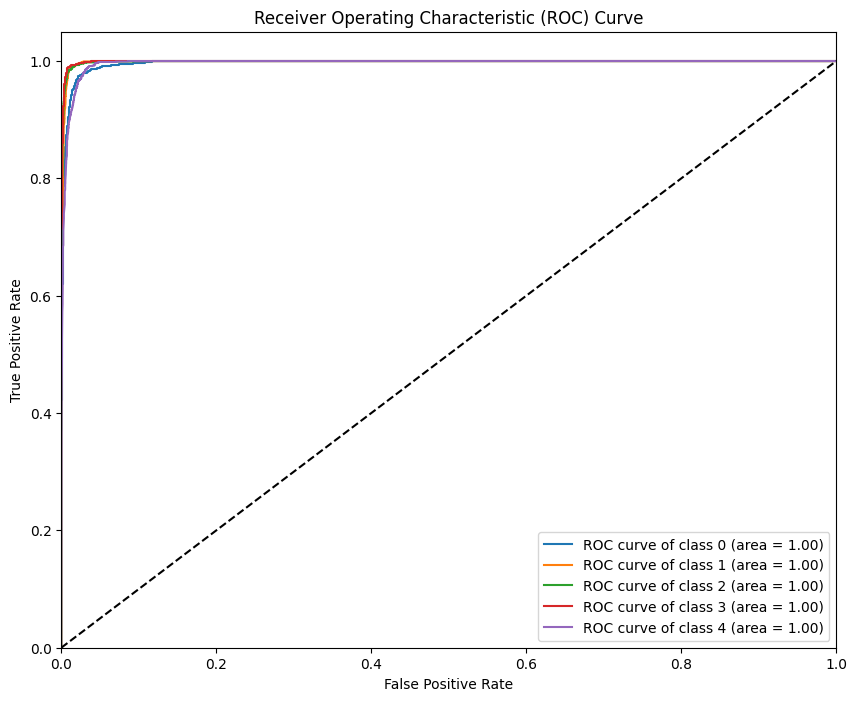

In [ ]:
# Binarizing the true labels 'y_val_fold' for multi-class classification with 12 classes (classes are labeled from 0 to 11)
y_test_bin = label_binarize(y_val_fold, classes=range(12))
#line 'label_binarize' translates labels into one-hot encoded format where each class label is represented by a binary vector
y_pred_bin = y_pred
# y_pred is already in the same format - this keeps it that way
fpr = dict()
# Initializing dictionaries to store the false positive rate
tpr = dict()
# true positive rate (tpr), and area under the curve
roc_auc = dict()
# Looping over each class (0 to 4 in your case)
for i in range(5):
  # Plot the ROC curve (fpr, tpr) for each class by using the true labels (y_test_bin) and predicted probabilities (y_pred_bin).
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    # Calculate the Area Under the Curve (AUC) for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Generating a figure for plotting ROC curves for each class
matplotlib.figure(figsize=(10, 8))

# Loop through each class (assuming there are 5 classes) to plot their respective ROC curves
for i in range(5):
    # Plot the ROC curve for class `i`, including the AUC (area under the curve) score in the legend
    matplotlib.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Draw a diagonal line that shows the performance of a random classifier (no discrimination ability).

matplotlib.plot([0, 1], [0, 1], 'k--')

# Plotting the ROC curves of all classes in multiclass classification
matplotlib.xlim([0.0, 1.0])
#These limits ensure that the ROC curve fits in the usual range [0, 1] for both axes
matplotlib.ylim([0.0, 1.05])
# Specifies to limit the x-axis (False Positive Rate) within the range o
matplotlib.xlabel('False Positive Rate')
# Labels on x and y
matplotlib.ylabel('True Positive Rate')
# Adding a title to the plot
matplotlib.title('Receiver Operating Characteristic (ROC) Curve')
# Add a legend to the plot at the bottom-right; matplotlib.legend(loc= "lower right") # Position legend
matplotlib.legend(loc="lower right")
# Print the plot with the ROC curves for each class
# Print final plot
matplotlib.show()


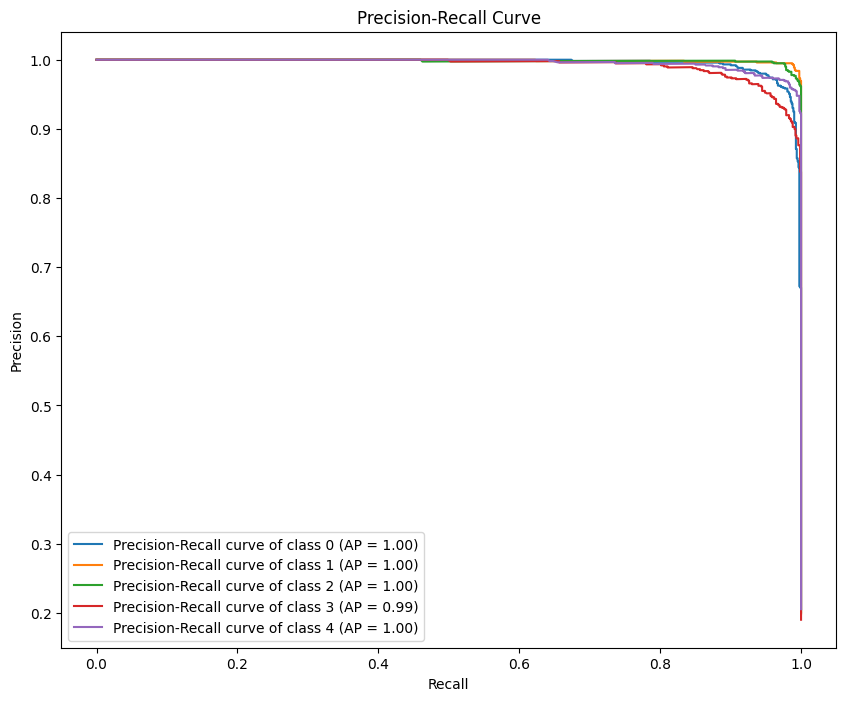

In [ ]:
#Initialize dictionaries: Initialize empty dictionaries to store precision, recall, and average precision for the 5 classes.
precision = dict()
#Loop over classes: Loop through classes to calculate precision and recall for classes.
recall = dict()
#Compute precision and recall: Use the function precision_recall_curve to compute precision and recall values for each class given the true labels y_test_bin and the predicted probabilities y_pred_bin.
average_precision = dict()
#Average precision score: Average_precision_score calculates the average precision score for each class, summarizing the precision-recall curve.

for i in range(5):
  #Set the figure size for the plot to 10x8 inches so that every plot has better visibility.
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
#For each class, plot its precision-recall curve, and it includes the average precision (AP) score in the legend.
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_bin[:, i])
# A title for the plot should be added and it should be stated that it plots the precision-recall curve.
matplotlib.figure(figsize=(10, 8))
for i in range(5):
   # A legend shall be included in the lower left corner which will indicate the class and its average precision score (AP).
    matplotlib.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))
#Precision-recall curve of all the classes should be displayed.
# Set the x-axis label
matplotlib.xlabel('Recall')

# Set the y-axis label
matplotlib.ylabel('Precision')

# Set the title of the plot
matplotlib.title('Precision-Recall Curve')

# Add a legend to the plot in the lower-left corner
matplotlib.legend(loc="lower left")

# Display the plot
matplotlib.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted classes for the first 10 images: [3 0 1 3 0 2 4 3 2 3]


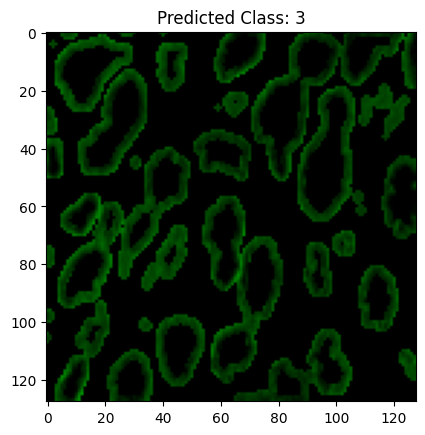

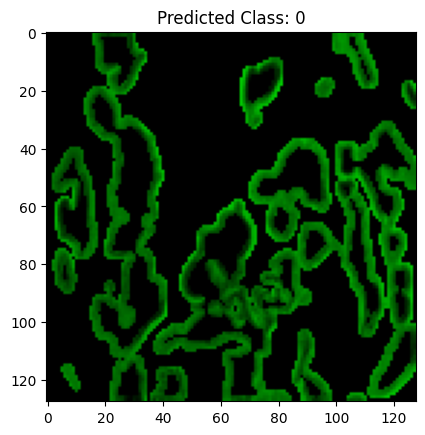

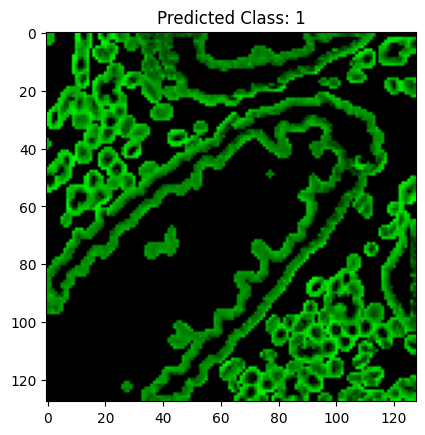

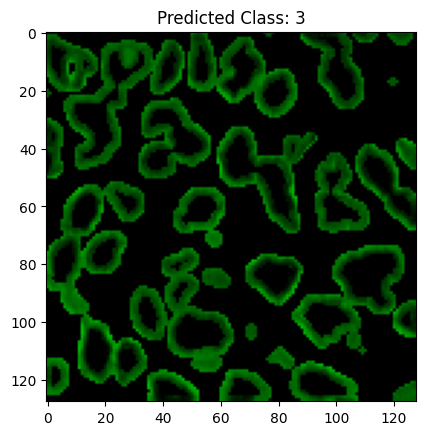

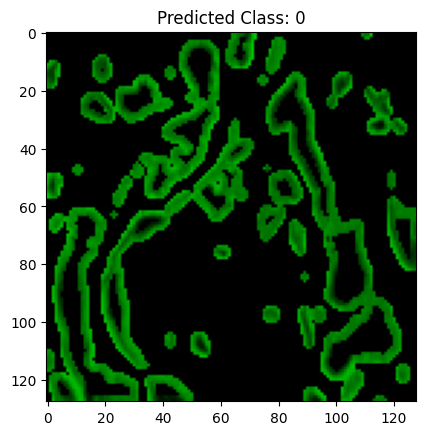

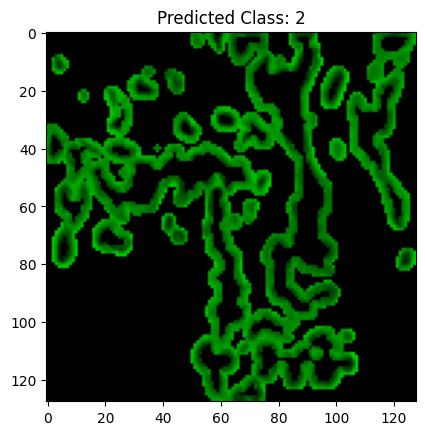

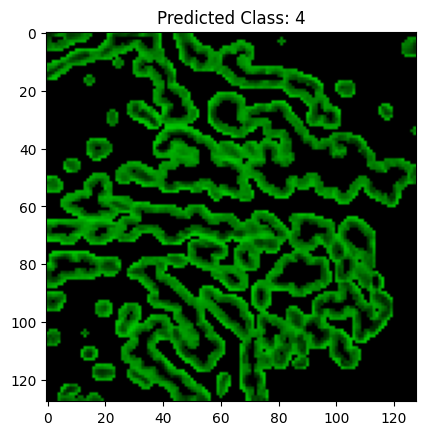

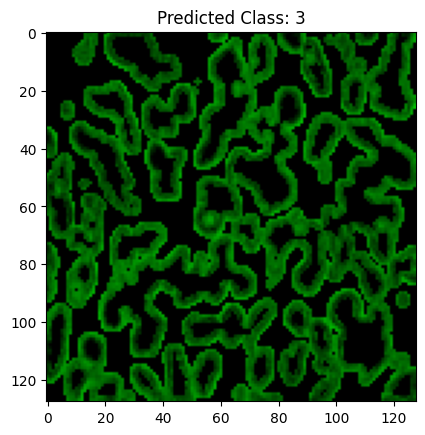

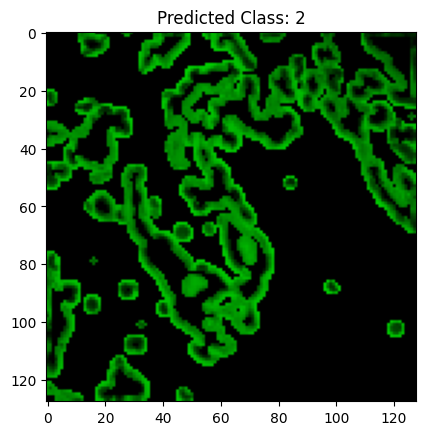

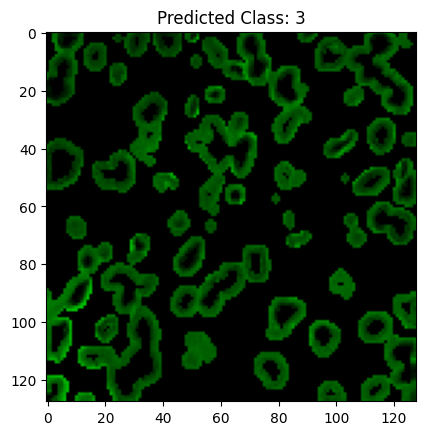

In [ ]:
#Predtion
predictions = hybrid_model1.predict(X_test[:10])

# Use argmax to translate the expected probability into class labels.
predicted_classes = np.argmax(predictions, axis=1)
# Print the first ten photos' projected classes.
print("Predicted classes for the first 10 images:", predicted_classes)

# It's optional to show the pictures together with their anticipated labels.
# Repeat the test set's first ten samples.
for i in range(10):
    # Show the picture from the test collection.
    matplotlib.imshow(X_test[i])

    # Configure the displayed image's title
    matplotlib.title(f"Predicted Class: {predicted_classes[i]}")

    # Display the picture together with the title.
    matplotlib.show()
